In [1]:
#Import the libraries
import math
import pandas_datareader as web
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

Using TensorFlow backend.


In [2]:
#Get the stock quote 
df = web.DataReader('AAPL', data_source='yahoo', start='2005-01-01', end='2020-03-20') 
#Show the data 
df
df.shape

(3830, 6)

E:\Anaconda3\envs\nlp\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


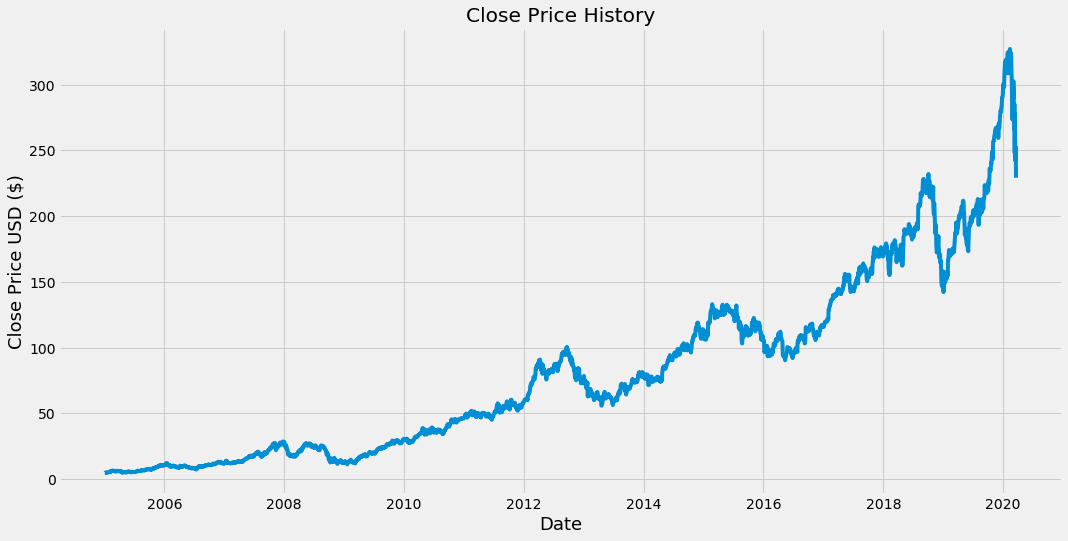

In [3]:
#Visualize the closing price history
plt.figure(figsize=(16,8))
plt.title('Close Price History')
plt.plot(df['Close'])
plt.xlabel('Date',fontsize=18)
plt.ylabel('Close Price USD ($)',fontsize=18)
plt.show()

In [4]:
#Create a new dataframe with only the 'Close' column
data = df.filter(['Close'])
#Converting the dataframe to a numpy array
dataset = data.values
#Get /Compute the number of rows to train the model on
training_data_len = math.ceil(len(dataset) *.8)

In [5]:
#Scale the all of the data to be values between 0 and 1
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)
                              
#Create the scaled training data set 
train_data = scaled_data[0:training_data_len  , : ]
#Split the data into x_train and y_train data sets
x_train=[]
y_train = []
for i in range(90,len(train_data)):
    x_train.append(train_data[i-90:i,0])
    y_train.append(train_data[i,0])

In [6]:
#Convert x_train and y_train to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)

#Reshape the data into the shape accepted by the LSTM
x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))

In [ ]:
#Build the LSTM network model
model = Sequential()
model.add(LSTM(units=100, return_sequences=True,input_shape=(x_train.shape[1],1)))
model.add(LSTM(units=1000, return_sequences=False))
model.add(Dense(units=50))
model.add(Dense(units=1))

#Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

#Train the model
model.fit(x_train, y_train, batch_size=2, epochs=10)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Epoch 1/10
2974/2974 [==============================] - 1876s 631ms/step - loss: 3.3877e-04
Epoch 2/10
2704/2974 [==========================>...] - ETA: 2:55 - loss: 6.8306e-05

In [20]:
#Test data set
test_data = scaled_data[training_data_len - 60: , : ]
#Create the x_test and y_test data sets
x_test = []
y_test =  dataset[training_data_len : , : ] #Get all of the rows from index 1603 to the rest and all of the columns (in this case it's only column 'Close'), so 2003 - 1603 = 400 rows of data
for i in range(60,len(test_data)):
    x_test.append(test_data[i-60:i,0])

#Convert x_test to a numpy array 
x_test = np.array(x_test)

#Reshape the data into the shape accepted by the LSTM
x_test = np.reshape(x_test, (x_test.shape[0],x_test.shape[1],1))

#Getting the models predicted price values
predictions = model.predict(x_test) 
predictions = scaler.inverse_transform(predictions)#Undo scaling

#Calculate/Get the value of RMSE
rmse=np.sqrt(np.mean(((predictions- y_test)**2)))
rmse

7.54940852247082

E:\Anaconda3\envs\nlp\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


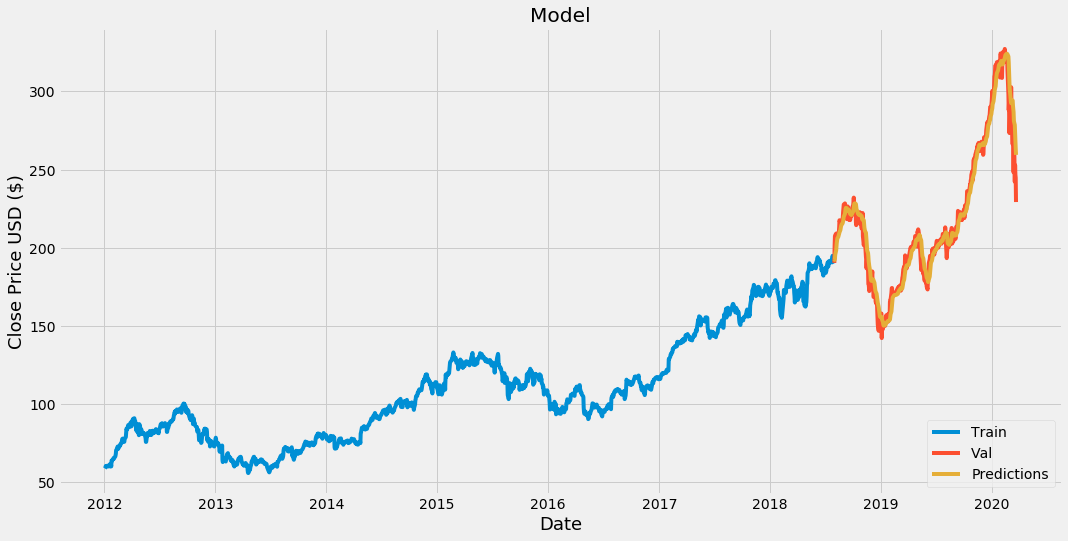

In [21]:
#Plot/Create the data for the graph
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions
#Visualize the data
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

In [22]:
valid

,Close,Predictions
Date,,
2018-07-31,190.289993,192.583801
2018-08-01,201.500000,192.180817
2018-08-02,207.389999,193.254440
2018-08-03,207.990005,195.611343
2018-08-06,209.070007,198.339188
...,...,...
2020-03-16,242.210007,278.557373
2020-03-17,252.860001,272.879364
2020-03-18,246.669998,268.179291


In [39]:
#Get the quote
apple_quote = web.DataReader('AAPL', data_source='yahoo', start='2019-12-23', end='2020-03-19')
#Create a new dataframe
new_df = apple_quote.filter(['Close'])
#Get teh last 60 day closing price 
last_60_days = new_df[-60:].values
#Scale the data to be values between 0 and 1
last_60_days_scaled = scaler.transform(last_60_days)
#Create an empty list
X_test = []
#Append teh past 60 days
X_test.append(last_60_days_scaled)
#Convert the X_test data set to a numpy array
X_test = np.array(X_test)
#Reshape the data
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
#Get the predicted scaled price
pred_price = model.predict(X_test)
#undo the scaling 
pred_price = scaler.inverse_transform(pred_price)
print(pred_price)

[[259.41284]]


In [40]:
#Get the quote
apple_quote2 = web.DataReader('AAPL', data_source='yahoo', start='2020-03-10', end='2020-03-19')
print(apple_quote2['Close'])

Date
2020-03-10    285.339996
2020-03-11    275.429993
2020-03-12    248.229996
2020-03-13    277.970001
2020-03-16    242.210007
2020-03-17    252.860001
2020-03-18    246.669998
2020-03-19    244.779999
Name: Close, dtype: float64
